# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

In [2]:
params = {
    'axes.labelsize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [7, 3.375],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'ytick.right': True,
    'xtick.top': True
   }
plt.rcParams.update(params)

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

### Ring parameters

In [2]:
N = 8  # number of transmons
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (5, 4), (6, 5), (7, 6), (0, 7)]  # edges
architecture = "CZ"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

### Constructing a FrequencyGraph object

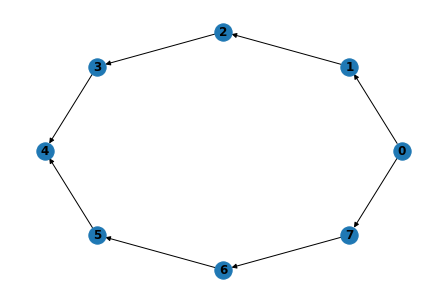

In [3]:
G = FrequencyGraph(edges=edges, cz=cz)
pos = {i: (np.cos(2*np.pi/N*i), (np.sin(2*np.pi/N*i))) for i in range(N)}
G.plot(pos = pos)

In [4]:
G.cz

True

In [5]:
#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

## Optimization of the frequency

### optimization parameters

In [6]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

### Optimization

In [7]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
optimizer.second_pass()
result = optimizer.third_pass()

### Adding the results to the frequencyGraph

In [8]:
# # manually adding the frequencyes and the drives
# freqs = np.array([ 5.63, 5.55, 5.40, 5.25, 5.05, 5.15, 5.3, 5.43])
# freqs = np.array([ 5.794, 5.659, 5.478, 5.297, 5.115, 5.240, 5.421, 5.603])
# freqs = {k: freqs[k] for k in range(8)}
# anharms = {k: -0.310 for k in range(8)}
# drives =  {e: freqs[e[1]] for e in G.edges}

In [9]:
# drives

In [10]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)

In [11]:
print(G.check_solution(d_dict, cstr=cstr_key))

True


[]

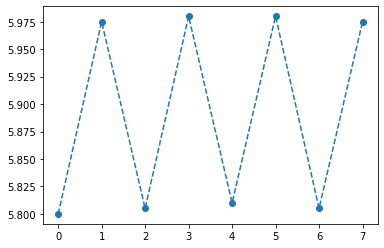

In [12]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.plot()

In [13]:
for n in G:
    print(G.nodes[n])

{'freq': 5.799999999999625, 'a': -0.35}
{'freq': 5.974999999999599, 'a': -0.35}
{'freq': 5.8049999999999615, 'a': -0.35}
{'freq': 5.979999999999936, 'a': -0.35}
{'freq': 5.810000000000019, 'a': -0.35}
{'freq': 5.979999999999998, 'a': -0.35}
{'freq': 5.805000000000058, 'a': -0.35}
{'freq': 5.974999999999565, 'a': -0.35}


In [14]:
# plotting
from matplotlib.patches import Rectangle
# pot distribution:
import scipy.stats as stats

In [15]:
G.drive

{(0, 1): 5.718999999999565,
 (0, 7): 5.7189999999995305,
 (1, 2): 5.718999999999599,
 (2, 3): 5.723999999999902,
 (3, 4): 5.723999999999902,
 (5, 4): 5.723999999999964,
 (6, 5): 5.723999999999998,
 (7, 6): 5.718999999999531}

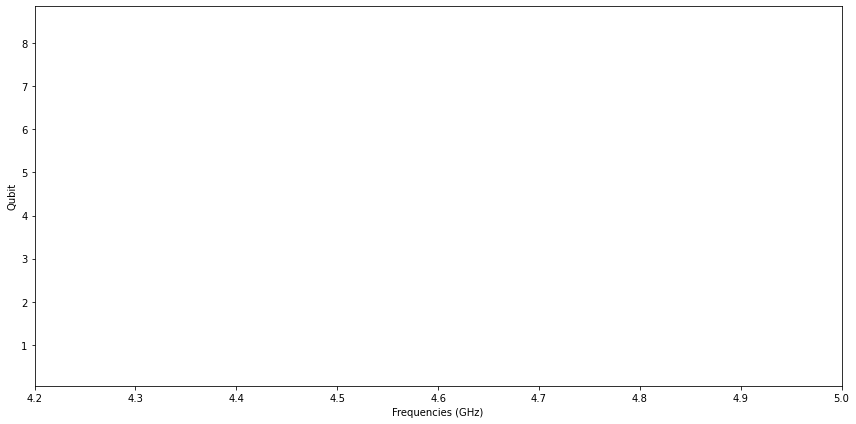

In [16]:
# sigma of the distribution of frequency
sigma = 0.02

fig, ax = plt.subplots(figsize=(12, 6))

# loop through the nodes
for n in G:
    
    #plot a dashed line at the position of the qubit frequencies
    ax.plot([G.nodes[n]['freq']]*2, [n+0.55,n+0.9+0.55], color='k', linestyle='-')
    ax.plot([G.nodes[n]['freq'] + G.nodes[n]['a']]*2, [n+0.55,n+0.9+0.55], color='k', linestyle='--')
    ax.plot([G.nodes[n]['freq'] + G.nodes[n]['a']/2]*2, [n+0.55,n+0.55 +.9], color='k', linestyle=':')
    
    ### Now the forbidden regions
    # A1 & A2
    neighbors = [G.nodes[(n+1) % 8], G.nodes[(n-1) % 8]]
    for neighbor in neighbors:
        ax.add_patch(Rectangle((neighbor['freq']-d_dict['A1'], n+0.55), 2*d_dict['A1'], 0.9,
                 facecolor = 'Gray',
                alpha= 0.2,
                 fill=True,
                 lw=5))
        ax.add_patch(Rectangle((neighbor['freq'] + neighbor['a']-d_dict['A2i'], n+0.55), 2*d_dict['A2i'], 0.9,
                                facecolor = 'Gray', alpha= 0.2, fill=True, lw=5))

for key, f in G.drive.items():
    ax.plot([f, f], [key[0]+0.45, key[0]+1+.45], color = 'red')
    ax.plot([f, f], [key[1]+0.45, key[1]+1+.45], color = 'red')
# # Entanglements E1
# for e in G.edges:
#     i, j = e
#     fj = G.nodes[j]['freq']
#     fi = G.nodes[i]['freq']
#     ai = G.nodes[i]['a']
# # #     ax.add_patch(Rectangle((f-d_dict['E1'], i), 2*d_dict['E1'], 0.9,
# # #                  facecolor = 'Blue',
# # #                 alpha= 0.2,
# # #                  fill=True,
# # #                  lw=5))

# #     ax.add_patch(Rectangle((fj-d_dict['E4']+ai/2, i+0.55), 2*d_dict['E4'], 0.9,
# #              facecolor = 'Blue',
# #             alpha= 0.2,
# #              fill=True,
# #              lw=5))
    
    
#     #### C constraint
#     ## fcontrol >= f target
#     ax.add_patch(Rectangle((fj, i+0.55), -2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5))
#     ax.add_patch(Rectangle((fi, j+0.55), 2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5)) 
#     ## fcontrol+acontrol >= f target
#     ax.add_patch(Rectangle((fj-ai, i+0.55), 2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5))
#     ax.add_patch(Rectangle((fi+ai, j+0.55), -2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5)) 
    
#     ## 2 photon transition: fj-fi-ai/2 >= delta
#     ax.add_patch(Rectangle((fi+ai/2-d_dict['E4'], j+0.55), 2*d_dict['E4'], 0.9,
#         facecolor = 'Blue',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

#     ax.add_patch(Rectangle((fj-ai/2-d_dict['E4'], i+0.55), 2*d_dict['E4'], 0.9,
#         facecolor = 'Blue',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

    
# ### Now the tricky contraint with 3 sites first the F constraints


# for i, j, k in G.cr_neighbhors:
#     ## F1: fj != fk
#     fj = G.nodes[j]['freq']
#     fi = G.nodes[i]['freq']
#     fk = G.nodes[k]['freq']
#     ak = G.nodes[k]['a']
#     ak = G.nodes[i]['a']
#     ax.add_patch(Rectangle((fk-d_dict['F1'], j+0.55), 2*d_dict['F1'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-d_dict['F1'], k+0.55), 2*d_dict['F1'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
    
#     ## F2
#     ax.add_patch(Rectangle((fk+ak-d_dict['F2'], j+0.55), 2*d_dict['F2'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-ak-d_dict['F2'], k+0.55), 2*d_dict['F2'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

#     ## M1:
#     ax.add_patch(Rectangle((fk-2*fi-ai-d_dict['M1'], j+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-2*fi-ai-d_dict['M1'], k+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle(( (fj+fk-ai)/2-d_dict['M1'], i+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5))     
    
for sigma, ls in zip([0.015, 0.05], ['-', '--']):

    for n in G.nodes:

        mu = G.nodes[n]['freq']
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)
        y /= np.max(y)
        ax.plot(x, n +0.55+ 0.9*y, color=f'C{n}', linestyle=ls)



ax.set_xlabel('Frequencies (GHz)')
ax.set_ylabel('Qubit')

ax.set_xlim(4.2, 5.0)

fig.tight_layout()
# plt.savefig('yield_8qring_sigma=50MHz.png')

# np.sum(result[1])/np.float(result[1].shape[0])
#an even nicer visualization would be to map this into a ring. 

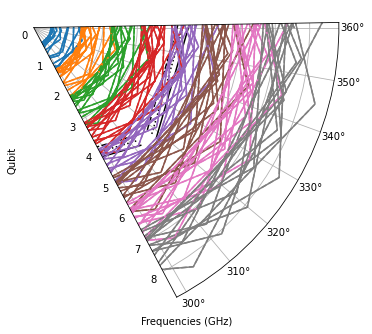

In [20]:
# sigma of the distribution of frequency
sigma = 0.02

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection':"polar"})

# loop through the nodes
for n in G:
    
    #plot a dashed line at the position of the qubit frequencies
    ax.plot([n+0.55,n+0.9+0.55],[G.nodes[n]['freq']]*2, color='k', linestyle='-')
    ax.plot([n+0.55,n+0.9+0.55],[G.nodes[n]['freq'] + G.nodes[n]['a']]*2, color='k', linestyle='--')
    ax.plot( [n+0.55,n+0.55 +.9],[G.nodes[n]['freq'] + G.nodes[n]['a']/2]*2, color='k', linestyle=':')
    
#     ### Now the forbidden regions
#     # A1 & A2
#     neighbors = [G.nodes[(n+1) % 8], G.nodes[(n-1) % 8]]
#     for neighbor in neighbors:
#         ax.add_patch(Rectangle((neighbor['freq']-d_dict['A1'], n+0.55), 2*d_dict['A1'], 0.9,
#                  facecolor = 'Gray',
#                 alpha= 0.2,
#                  fill=True,
#                  lw=5))
#         ax.add_patch(Rectangle((neighbor['freq'] + neighbor['a']-d_dict['A2i'], n+0.55), 2*d_dict['A2i'], 0.9,
#                                 facecolor = 'Gray', alpha= 0.2, fill=True, lw=5))
    
# # Entanglements E1
# for e in G.edges:
#     i, j = e
#     fj = G.nodes[j]['freq']
#     fi = G.nodes[i]['freq']
#     ai = G.nodes[i]['a']
# # #     ax.add_patch(Rectangle((f-d_dict['E1'], i), 2*d_dict['E1'], 0.9,
# # #                  facecolor = 'Blue',
# # #                 alpha= 0.2,
# # #                  fill=True,
# # #                  lw=5))

# #     ax.add_patch(Rectangle((fj-d_dict['E4']+ai/2, i+0.55), 2*d_dict['E4'], 0.9,
# #              facecolor = 'Blue',
# #             alpha= 0.2,
# #              fill=True,
# #              lw=5))
    
    
#     #### C constraint
#     ## fcontrol >= f target
#     ax.add_patch(Rectangle((fj, i+0.55), -2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5))
#     ax.add_patch(Rectangle((fi, j+0.55), 2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5)) 
#     ## fcontrol+acontrol >= f target
#     ax.add_patch(Rectangle((fj-ai, i+0.55), 2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5))
#     ax.add_patch(Rectangle((fi+ai, j+0.55), -2.0, 0.9,
#             facecolor = 'Red',
#             alpha= 0.15,
#             fill=True,
#             lw=5)) 
    
#     ## 2 photon transition: fj-fi-ai/2 >= delta
#     ax.add_patch(Rectangle((fi+ai/2-d_dict['E4'], j+0.55), 2*d_dict['E4'], 0.9,
#         facecolor = 'Blue',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

#     ax.add_patch(Rectangle((fj-ai/2-d_dict['E4'], i+0.55), 2*d_dict['E4'], 0.9,
#         facecolor = 'Blue',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

    
### Now the tricky contraint with 3 sites first the F constraints


# for i, j, k in G.cr_neighbhors:
#     ## F1: fj != fk
#     fj = G.nodes[j]['freq']
#     fi = G.nodes[i]['freq']
#     fk = G.nodes[k]['freq']
#     ak = G.nodes[k]['a']
#     ak = G.nodes[i]['a']
#     ax.add_patch(Rectangle((fk-d_dict['F1'], j+0.55), 2*d_dict['F1'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-d_dict['F1'], k+0.55), 2*d_dict['F1'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
    
#     ## F2
#     ax.add_patch(Rectangle((fk+ak-d_dict['F2'], j+0.55), 2*d_dict['F2'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-ak-d_dict['F2'], k+0.55), 2*d_dict['F2'], 0.9,
#         facecolor = 'Green',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 

#     ## M1:
#     ax.add_patch(Rectangle((fk-2*fi-ai-d_dict['M1'], j+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle((fj-2*fi-ai-d_dict['M1'], k+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5)) 
#     ax.add_patch(Rectangle(( (fj+fk-ai)/2-d_dict['M1'], i+0.55), 2*d_dict['M1'], 0.9,
#         facecolor = 'Yellow',
#         alpha= 0.15,
#         fill=True,
#         lw=5))     
    
for sigma, ls in zip([0.015, 0.05], ['-', '--']):

    for n in G.nodes:

        mu = G.nodes[n]['freq']
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)
        y /= np.max(y)
        ax.plot(n +0.55+ 0.9*y, color=f'C{n}', linestyle=ls)



ax.set_xlabel('Frequencies (GHz)')
ax.set_ylabel('Qubit')

ax.set_xlim(5.2, 6.3)

fig.tight_layout()
# plt.savefig('yield_8qring_sigma=50MHz.png')

# np.sum(result[1])/np.float(result[1].shape[0])
#an even nicer visualization would be to map this into a ring. 

## Yield of the design

In [ ]:
# parametrization
Nsamples = 100
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples, reoptimize=True)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")

c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples



Qubit collisions:
yield   = 0.69
average = 1.84


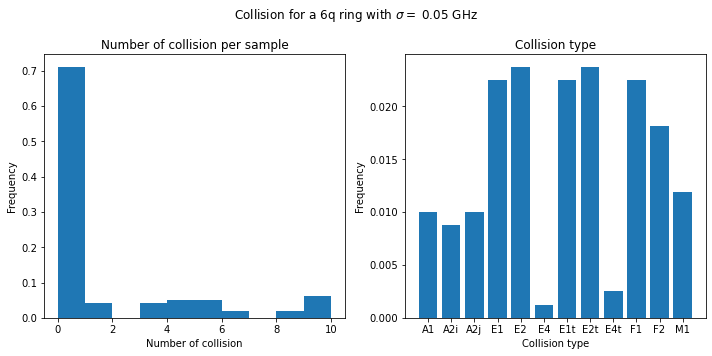

In [15]:
###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

### Collision type distribution

### Collision spatial distribution

In [16]:
x = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
xm = [(x[i] + x[i+1])/2 for i in range(len(x)-1)]

Text(0.5, 0, 'Collision type')

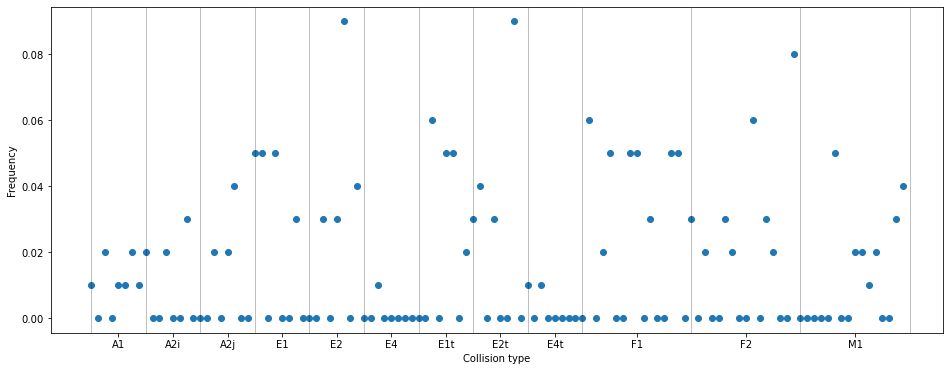

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.sum(~np.array(c), axis=1)/Nsamples, 'o')
for xx in x:
    ax.axvline(xx, color='k', linewidth=0.5, alpha = 0.5)
ax.set_xticks(xm);
ax.set_xticklabels(constraints)

ax.set_ylabel('Frequency')
ax.set_xlabel("Collision type")

### Collision vs std of the frequencies

0.0
4.761904761904762
9.523809523809524
14.285714285714285
19.047619047619047
23.809523809523807
28.57142857142857
33.33333333333333
38.095238095238095
42.857142857142854
47.61904761904761
52.38095238095239
57.14285714285714
61.904761904761905
66.66666666666666
71.42857142857143
76.19047619047619
80.95238095238095
85.71428571428571
90.47619047619048
95.23809523809523


(0.1, 1.1)

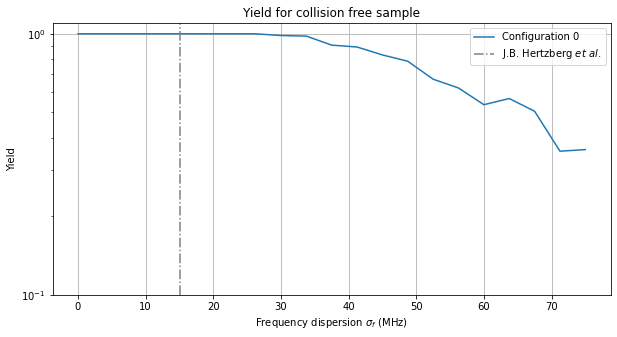

In [17]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 200

# varying the dispersion of the frequency
s_vec = np.linspace(0.00, 0.075, 21)

# saving the results
collisions = []
for k, s in enumerate(s_vec):
    print(k/len(s_vec)*100)
    
    collisions.append(G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key, reoptimize=True)[0])
collisions = np.array(collisions)

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
ax.set_ylim(0.1, 1.1)

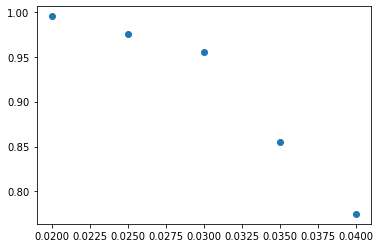

In [42]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 200

# varying the dispersion of the frequency
s_vec = np.linspace(0.00, 0.075, 21)

# saving the results
collisions = []
for k, s in enumerate(s_vec):
    print(k/len(s_vec)*100)
    
    collisions.append(G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key, reoptimize=True)[0])
collisions = np.array(collisions)

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
ax.set_ylim(0.1, 1.1)

In [11]:
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [7, 3.375],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'ytick.right': True,
    'xtick.top': True
   }
plt.rcParams.update(params)

In [46]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield.npy',data)

In [18]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]
data_CZ = np.load('ring_8t_CZ_yield.npy', allow_pickle=True)[()]

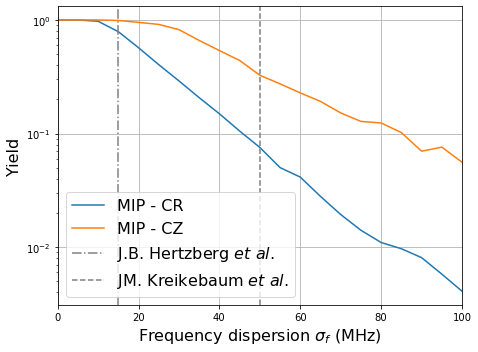

In [23]:
fig, ax = plt.subplots(figsize=(2*3.375, 2*2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data_CZ["sigma"]
y_cz = data_CZ["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield', fontsize= 16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=16, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

fig.savefig("fig_yield_ring.pdf")

In [53]:
data_CR

array({'sigma': array([0.     , 0.00125, 0.0025 , 0.00375, 0.005  , 0.00625, 0.0075 ,
       0.00875, 0.01   , 0.01125, 0.0125 , 0.01375, 0.015  , 0.01625,
       0.0175 , 0.01875, 0.02   , 0.02125, 0.0225 , 0.02375, 0.025  ,
       0.02625, 0.0275 , 0.02875, 0.03   , 0.03125, 0.0325 , 0.03375,
       0.035  , 0.03625, 0.0375 , 0.03875, 0.04   , 0.04125, 0.0425 ,
       0.04375, 0.045  , 0.04625, 0.0475 , 0.04875, 0.05   , 0.05125,
       0.0525 , 0.05375, 0.055  , 0.05625, 0.0575 , 0.05875, 0.06   ,
       0.06125, 0.0625 , 0.06375, 0.065  , 0.06625, 0.0675 , 0.06875,
       0.07   , 0.07125, 0.0725 , 0.07375, 0.075  , 0.07625, 0.0775 ,
       0.07875, 0.08   , 0.08125, 0.0825 , 0.08375, 0.085  , 0.08625,
       0.0875 , 0.08875, 0.09   , 0.09125, 0.0925 , 0.09375, 0.095  ,
       0.09625, 0.0975 , 0.09875, 0.1    ]), 'collisions': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 8, 5, ..., 3, 8, 3],
       [5, 4, 4

In [76]:
ord?

Signature: ord(c, /)
Docstring: Return the Unicode code point for a one-character string.
Type:      builtin_function_or_method
